In [ ]:
cd /content

/content


In [ ]:
!ls

sample_data


In [ ]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

Cloning into 'google-colab-cs231n'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 5.07 MiB | 18.54 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [ ]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
get_datasets.sh


In [ ]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [ ]:
!./get_datasets.sh

--2022-03-12 15:11:13--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  74.0MB/s    in 2.2s    

2022-03-12 15:11:15 (74.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import tensorflow as tf

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2


import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


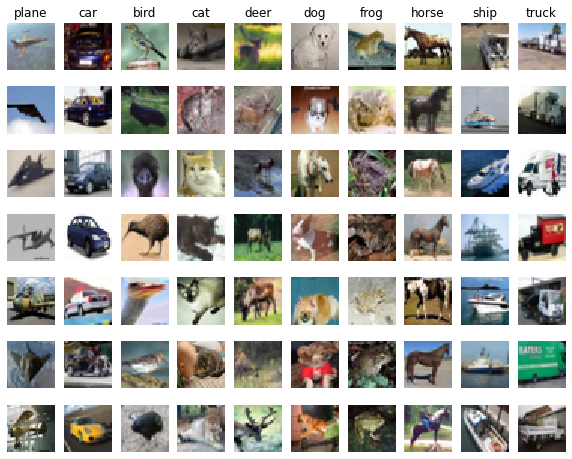

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

accuracy1 = []

for k in range(1, 21):
  print("k: ", k)
  acc = []
  for f in range(5):
    # divide data into folds
    validationX, validationY = X_train[f*10000:(f+1)*10000], Y_train[f*10000:(f+1)*10000]
    trainX = np.concatenate((X_train[:f*10000], X_train[(f+1)*10000:]), axis = 0)
    trainY = np.concatenate((Y_train[:f*10000], Y_train[(f+1)*10000:]), axis = 0)
    cm = ce = 0         # c for correct, m for manhattan, e for euclidean

    for i in range(len(validationX)):
      man_distance = []
      euc_distance = []

      for j in range(len(trainX)):
        
        # manhattan - calculating distance between two images
        l1 = np.sum(np.absolute(np.subtract(validationX[i], trainX[j])))

        # euclidean - calculation distance between two images
        l2 = np.sqrt(np.sum((validationX[i] - trainX[j])**2))

        man_distance.append([l1, trainY[j][0]])
        euc_distance.append([l2, trainY[j][0]])
        
        if j == 400:
            break

      man_distance = np.array(man_distance)
      man_distance = man_distance[man_distance[:, 0].argsort()]
      euc_distance = np.array(euc_distance)
      euc_distance = euc_distance[euc_distance[:, 0].argsort()]
      
      # for manhattan distance
      values = man_distance[:k, 1]

      # print(values)
      most_frequent_value = np.argmax(np.bincount(values.astype('int32')))

      # print(most_frequent_value)
      if most_frequent_value == validationY[i]:
        cm += 1
        
      # for euclidean distance
      values = euc_distance[:k, 1]
      most_frequent_value = np.argmax(np.bincount(values.astype('int32')))
      if most_frequent_value == validationY[i]:
        ce += 1

      # print(man_distance[0][0], man_distance[-1][0])
      # print(euc_distance[0], euc_distance[-1])

      if i == 120:
        break

    acc.append([cm/100, ce/100])
  accuracy1.append([acc, k])

print(accuracy1)

k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
[[[[0.18, 0.18], [0.29, 0.21], [0.17, 0.12], [0.24, 0.21], [0.13, 0.14]], 1], [[[0.17, 0.11], [0.21, 0.24], [0.19, 0.15], [0.24, 0.22], [0.16, 0.14]], 2], [[[0.27, 0.12], [0.27, 0.18], [0.18, 0.18], [0.25, 0.18], [0.14, 0.15]], 3], [[[0.2, 0.17], [0.29, 0.29], [0.19, 0.17], [0.2, 0.25], [0.16, 0.18]], 4], [[[0.13, 0.17], [0.25, 0.24], [0.2, 0.18], [0.24, 0.23], [0.12, 0.19]], 5], [[[0.14, 0.16], [0.24, 0.2], [0.21, 0.18], [0.25, 0.2], [0.16, 0.17]], 6], [[[0.16, 0.17], [0.27, 0.22], [0.18, 0.17], [0.25, 0.19], [0.21, 0.2]], 7], [[[0.2, 0.2], [0.28, 0.2], [0.24, 0.18], [0.22, 0.21], [0.2, 0.23]], 8], [[[0.15, 0.16], [0.28, 0.21], [0.22, 0.19], [0.23, 0.21], [0.22, 0.22]], 9], [[[0.17, 0.15], [0.27, 0.24], [0.22, 0.2], [0.27, 0.24], [0.25, 0.22]], 10], [[[0.19, 0.13], [0.26, 0.19], [0.23, 0.22], [0.23, 0.28], [0.25, 0.23]], 11], [[[0.17, 0.14], [0.24, 0.2], [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


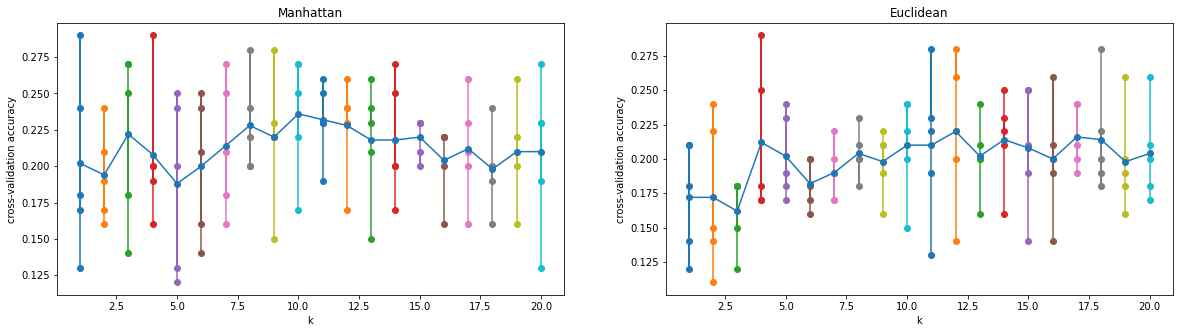

In [ ]:
avg1 = []
avg2 = []
k = np.array(accuracy1)[:,1]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Manhattan')
for i in range(len(accuracy1)):
  a = np.full((5), i+1, dtype=int)
  l1 = np.array(accuracy1[i][0])[:,0]
  avg1.append(np.average(l1))
  plt.plot(a, l1, 'o-')
  
plt.plot(k, avg1, 'o-')
plt.xlabel('k')
plt.ylabel('cross-validation accuracy')


plt.subplot(1,2,2)
plt.title('Euclidean')
for i in range(len(accuracy1)):
  a = np.full((5), i+1, dtype=int)
  l2 = np.array(accuracy1[i][0])[:,1]
  avg2.append(np.average(l2))
  plt.plot(a, l2, 'o-')

plt.plot(k, avg2, 'o-')
plt.xlabel('k')
plt.ylabel('cross-validation accuracy')

plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


In [ ]:
pretty_print(classifier.compute_distances_two_loops)

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

In [ ]:
plt.imshow(dists, interpolation='none')
plt.show()

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [ ]:
pretty_print(classifier.compute_distances_one_loop)

dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
pretty_print(classifier.compute_distances_no_loops)

dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 31.196658 seconds
One loop version took 44.668673 seconds
No loop version took 0.605190 seconds


In [ ]:
num_folds = 5
k_choices = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

if num_training/num_folds % num_folds != 0.0:
    raise ValueError('Number of training examples not evenly divisible by number of folds.')

X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []
    
for idx in range(num_folds):
    X_train_set = np.concatenate((*X_train_folds[:idx], *X_train_folds[idx+1:]), axis=0)
    y_train_set = np.concatenate((*y_train_folds[:idx], *y_train_folds[idx+1:]), axis=0)
    X_validation_set = X_train_folds[idx]
    y_validation_set = y_train_folds[idx]   
    num_validation_set = X_validation_set.shape[0]
    # Train kNN classifier
    classifier = KNearestNeighbor()
    classifier.train(X_train_set, y_train_set)
    # Compute distances
    dists_validate = classifier.compute_distances_no_loops(X_validation_set)
    for k in k_choices:
        y_validation_pred = classifier.predict_labels(dists_validate, k=k)
        # Check accuracy
        accuracy = (float(np.sum(np.equal(y_validation_pred, y_validation_set)))/num_validation_set)
        k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 2, accuracy = 0.235000
k = 2, accuracy = 0.219000
k = 2, accuracy = 0.234000
k = 2, accuracy = 0.247000
k = 2, accuracy = 0.252000
k = 4, accuracy = 0.259000
k = 4, accuracy = 0.270000
k = 4, accuracy = 0.269000
k = 4, accuracy = 0.294000
k = 4, accuracy = 0.272000
k = 6, accuracy = 0.253000
k = 6, accuracy = 0.277000
k = 6, accuracy = 0.274000
k = 6, accuracy = 0.273000
k = 6, accuracy = 0.282000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 14, accuracy = 0.263000
k = 14, accuracy 

k = 1, average accuracy = 0.265600
k = 2, average accuracy = 0.237400
k = 4, average accuracy = 0.272800
k = 6, average accuracy = 0.271800
k = 8, average accuracy = 0.276000
k = 10, average accuracy = 0.280200
k = 12, average accuracy = 0.279400
k = 14, average accuracy = 0.282000
k = 16, average accuracy = 0.275600
k = 18, average accuracy = 0.277600
k = 20, average accuracy = 0.279000


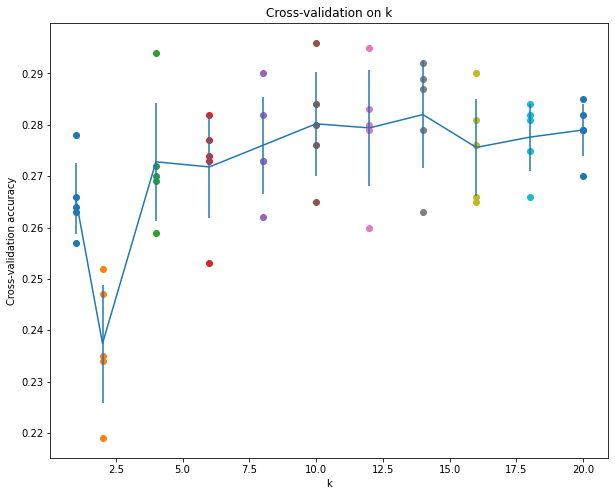

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    print('k = %d, average accuracy = %f' % (k, np.average(accuracies)))
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# data. Get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Discussion:**

**What is KNN?**

K nearest neighbors (KNN) is a supervised machine learning algorithm. A supervised machine learning algorithm’s goal is to learn a function such that f(X) = Y where X is the input, and Y is the output. KNN can be used both for classification as well as regression. The k-nearest neighbors (KNN) algorithm is a simple, easy-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems.

**Application of KNN:**

1. Credit score: The KNN algorithm compares an individual's credit rating to others with comparable characteristics to help calculate their credit rating.
2. Approval of the loan: The k-nearest neighbor technique, similar to credit scoring, is useful in detecting people who are more likely to default on loans by comparing their attributes to those of similar people.
3. Prediction of stock prices: The KNN algorithm is useful in estimating the future value of stocks based on previous data since it has a knack for anticipating the prices of unknown entities.
4. Computer Vision: For picture classification, the KNN algorithm is used. It's important in a variety of computer vision applications since it can group comparable data points together, such as cats and dogs in separate classes.

**Is KNN is a good/bad choice for image classification?**

KNN is a bad choice for image classification. 
1. Does not work well with large dataset: In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.

2. Does not work well with high dimensions: The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.

KNNs take more time to predict than CNNs It has to run through all of the dataset and manually search for differences and similarities, takes O(n) time to predict for a dataset with n images. KNNs don't generalise as well as CNNs KNNs localise features and only remember features at a particular spot, while CNNs can generalize it to any part of an image. For better outcomes, we should employ a convolutional neural network (CNN).